## Global variables

In [ ]:
prevalence_GP = 0.0112                                                          # prevalence is the ratio of people in a population who have schizophrenia
penetrance_GP = 0.5                                                             # penetrance is the ratio of people with schizophrenia genetic conditions who actually have the illness          
                                                                                # Thus, prevalence/penetration is the ratio of people in a population who have schizophrenia genetic conditions

## Modules

In [ ]:
import math
from scipy.stats import binom
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pylab as pylab

## Calculating pathogenic genotype and allele freqs in all populations

In [ ]:
def find_min_p_G_GP(N,T,prevalence=prevalence_GP,penetrance=penetrance_GP):     # Calculates pathogenic genotype freq in general population
    p_G_GP = 0                                                                  # Option 1, more elegant, more efficient, innovative
    target = prevalence / penetrance                                            # dynamically defined variables to allow calculation for patients' relatives using same function (compactibility)
    num_iter = 500                                                              # sufficiently high number to handle any rogue cases, while producing correct result
    
    if(T > 0.1):                                                                # smart selection of lr, after trials, to minimize the total # of iterations 
        lr = 1                                                                  # larger lr for most T values
    else:
        lr = 0.1                                                                # smaller lr set for sensitive T values (≤ 0.1)
    
    for i in range(num_iter):
        dist = [binom.pmf(r,N,p_G_GP) for r in range(N+1)]                      # array of PMF of B(N,p_G_GP) probabilities for k = 0, 1, 2, ..., N
        supra_prob = sum(dist[math.ceil(N*T):])                                 # sum of probabilities for k ≥ N•T
        p_G_GP = p_G_GP + lr * (target - supra_prob)                            # gradient ascent

        if(abs(supra_prob - target) < 1e-5):                                    # provision to save computation if the desired value is within specified precision; < 1e-5 means 4 decimal points
            # print(i)                                                          # debugger to check the value of iters for various N,T pairs, to set optimum lr
            break                        
    return p_G_GP

'''def find_min_p_G_GP(N,T):                                                    # Option 2, standard, inefficient, computationally very expensive, will take over 1 hour to plot, while option 1 takes ~3 mins
    p_G_GP = 0                                                                  # Undeleted, left here for comparision
    target = 0.0224
    num_iter = 1000
    
    for i in range(num_iter):
        dist = [binom.pmf(r,N,p_G_GP) for r in range(N+1)]
        supra_prob = sum(dist[math.ceil(N*T)-1:])
        p_G_GP = p_G_GP + 0.001
        
        if(supra_prob >= target):
            break
 
    return p_G_GP
'''

def calc_p_A_GP(p_G_GP):                                                        # Calculates pathogenic allele freq in general population
    return 1 - math.sqrt(1 - p_G_GP)                                            # using formulae from appendices

def calc_p_G_PP(p_G_GP,N,T):                                                    # Calculates pathogenic genotype freq in patient population
    dist = [binom.pmf(r,N,p_G_GP) for r in range(N+1)]                          # using formulae from appendices
    prod = [r * binom.pmf(r,N,p_G_GP) for r in range(N+1)]
    
    return (sum(prod[math.ceil(N*T):])/sum(dist[math.ceil(N*T):]))/N
    
def calc_p_A_PP(p_G_PP, p_A_GP, p_G_GP):                                        # Calculates pathogenic allele freq in patient population
    return p_G_PP * p_A_GP / p_G_GP                                             # using formulae from appendices
    
def calc_p_G_NP(p_A_NP,p_A_GP,p_G_GP):                                          # Calculates pathogenic genotype freq in non-patient population
    return p_A_NP * p_G_GP / p_A_GP                                             # using formulae from appendices

def calc_p_A_NP(p_A_GP,p_A_PP,prevalence=prevalence_GP):                        # Calculates pathogenic allele freq in non-patient population
    return (p_A_GP - (prevalence * p_A_PP)) / (1 - prevalence)                  # using formulae from appendices

def all_prob_all_pop(N,T):                                                      # Master function to calculate all 6 freqs directly: pathogenic genotype and allele freqs for GP,PP,NP
    p_G_GP = find_min_p_G_GP(N,T)
    p_A_GP = calc_p_A_GP(p_G_GP)
    p_G_PP = calc_p_G_PP(p_G_GP,N,T)
    p_A_PP = calc_p_A_PP(p_G_PP, p_A_GP, p_G_GP)
    p_A_NP = calc_p_A_NP(p_A_GP,p_A_PP)
    p_G_NP = calc_p_G_NP(p_A_NP,p_A_GP,p_G_GP)
    return p_G_GP, p_A_GP, p_G_PP, p_A_PP, p_G_NP, p_A_NP

def PP_NP_diffs(N,T):                                                           # Supplementary function to directly calculate freq difference between PP and NP from N, T pair
    p_G_GP, p_A_GP, p_G_PP, p_A_PP, p_G_NP, p_A_NP = all_prob_all_pop(N,T)      # May come in handy for further work, not used as of now
    diff_G_PP_NP = p_G_PP - p_G_NP
    diff_A_PP_NP = p_A_PP - p_A_NP
    return diff_G_PP_NP, diff_A_PP_NP 

## Plotting all frequencies for all generations (Fig 2 and 3 in original research paper)

In [ ]:
def plot_fig2_fig3():

    fig = plt.figure(figsize=(15,105))

    N_vals = [10*i for i in range(2,17)]                                        # 20, 30, ..., 160  (15 values)
    T_vals = [0.05*i for i in range(1,19)]                                      # 0.05, 0.10, ..., 0.90 (18 values)
    N_vals.reverse()

    X, Y = np.meshgrid(N_vals, T_vals)                                          # mesh grid of 15 × 18 = 270 pairs
    Z = np.zeros(shape=(6,len(T_vals), len(N_vals)))                            # numpy array to hold results
    titles = ['p_A_NP: Allele frequency in NP according to N & T',              # subplot titles
              'p_A_PP: Allele frequency in PP according to N & T',
              'p_A_PP - p_A_NP: Allele frequency Difference between PP & NP',
              'p_G_NP: Genotype frequency in NP according to N & T',
              'p_G_PP: Genotype frequency in PP according to N & T',
              'p_G_PP - p_G_NP: Genotype frequency Difference between PP & NP']
                                                         
    for i in range(len(N_vals)):                                                # actual calculations; saved in Z
        N = N_vals[i]
        for j in range(len(T_vals)):
            T = T_vals[j]
            p_G_GP, p_A_GP, p_G_PP, p_A_PP, p_G_NP, p_A_NP = all_prob_all_pop(N,T)
            Z[0][j][i] = p_A_NP
            Z[1][j][i] = p_A_PP
            Z[2][j][i] = p_A_PP - p_A_NP
            Z[3][j][i] = p_G_NP
            Z[4][j][i] = p_G_PP
            Z[5][j][i] = p_G_PP - p_G_NP

    for k in range(6):                                                          # plotting 6 3D plots
        ax = fig.add_subplot(7, 1, k+1,projection='3d')      
        ax.invert_xaxis()                                                       # inverted axis to match research paper plot orientation
        surf = ax.plot_surface(X, Y, Z[k], cmap='Greys', antialiased=True)
        ax.set_title(titles[k],weight='bold')
        ax.set_xlabel('N',weight='bold')
        ax.set_ylabel('T',weight='bold')
        fig.colorbar(surf, shrink=0.5, aspect=5)                                # colorbar added for each 3D plot

    p_G_PP_vals = np.array(Z[4])                                                # plotting the 7th 2D plot: p_G_PP averaged over N
    plt.style.use('seaborn-whitegrid')
    ax = fig.add_subplot(7,1,7)
    ax.plot(T_vals,p_G_PP_vals.mean(axis=1))
    ax.set_title('p_G_PP: Genotype frequency & T',weight='bold')
    ax.set_xlabel('T',weight='bold')
    ax.set_ylabel('Mean p_G_PP',weight='bold')
    
    plt.show()

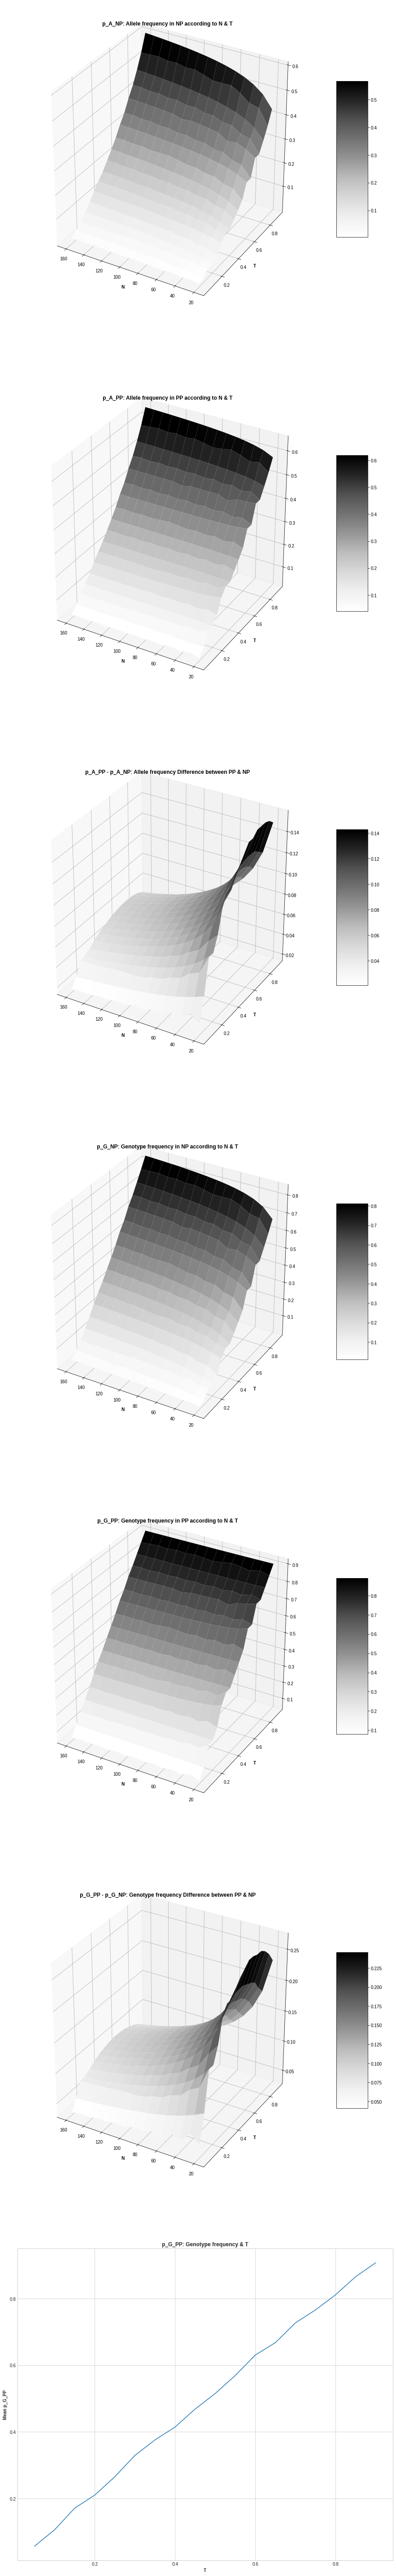

In [ ]:
plot_fig2_fig3()    # will take ~3m 10s to run, be patient :)

##Calculating genotype frequencies and prevalence for all types of offsprings

In [ ]:
'''def calc_p_G_GP_for_GP_GP_offspring(p_A_GP):                                 # not required as we can observe that p_G_GP_for_GP_GP_offspring = p_G_GP (of parent population)
    return 1 - (1 - p_A_GP)**2                                                  # similarily, p_A_GP_for_GP_GP_offspring = p_A_GP
'''
def calc_p_G_GP_for_PP_PP_offspring(p_A_PP):                                    # Calculates pathogenic genotype freq for PP × PP offspring
    return 1 - (1 - p_A_PP)**2

def calc_p_G_GP_for_PP_NP_offspring(p_A_PP,p_A_NP):                             # Calculates pathogenic genotype freq for PP × NP offspring
    return 1 - (1 - p_A_PP) * (1 - p_A_NP)

def calc_p_G_GP_for_NP_NP_offspring(p_A_NP):                                    # Calculates pathogenic genotype freq for NP × NP offspring
    return 1 - (1 - p_A_NP)**2

def calc_all_offspring_p_G_GP(N,T):                                             # master function to get the above 3 freqs from just N and T
    p_G_GP, p_A_GP, p_G_PP, p_A_PP, p_G_NP, p_A_NP = all_prob_all_pop(N,T)
    p_G_GP_PP_PP_offspring = calc_p_G_GP_for_PP_PP_offspring(p_A_PP)
    p_G_GP_PP_NP_offspring = calc_p_G_GP_for_PP_NP_offspring(p_A_PP,p_A_NP)
    p_G_GP_NP_NP_offspring = calc_p_G_GP_for_NP_NP_offspring(p_A_NP)
    return p_G_GP_PP_PP_offspring,p_G_GP_PP_NP_offspring,p_G_GP_NP_NP_offspring

def calc_prevalence(p_G,N,T,penetrance):                                        # calculates prevalence
    dist = [binom.pmf(r,N,p_G) for r in range(N+1)]                             # array of PMF of B(N,p_G_GP) probabilities for k = 0, 1, 2, ..., N
    supra_prob = sum(dist[math.ceil(N*T):])
    return penetrance * supra_prob


## Understanding the effects of PP inbreeding (Innovation component)

In [ ]:
def PP_inbreeding_analysis(N,T,num_gens):

    p_G_GP_vals = []                                                            # declared lists to hold results
    p_A_GP_vals = []
    p_G_PP_vals = []
    p_A_PP_vals = []
    prevalence_vals = []

    p_G_GP,p_A_GP,p_G_PP,p_A_PP,_,_ = all_prob_all_pop(N,T)                     # gen 0 values
    prevalence = prevalence_GP

    p_G_GP_vals.append(p_G_GP)                                                  # initialied with gen 0 values
    p_A_GP_vals.append(p_A_GP)
    p_G_PP_vals.append(p_G_PP)
    p_A_PP_vals.append(p_A_PP)
    prevalence_vals.append(prevalence)
    
    for i in range(num_gens - 1):                                                   # run for (num_gene - 1) times
        p_G_GP_for_PP_PP_offspring = calc_p_G_GP_for_PP_PP_offspring(p_A_PP)        # calculations for 4 values for next gen from that of current gen
        p_A_GP_for_PP_PP_offspring = p_G_GP_for_PP_PP_offspring * (p_A_GP / p_G_GP)
        p_G_PP_for_PP_PP_offspring = calc_p_G_PP(p_G_GP_for_PP_PP_offspring,N,T)
        p_A_PP_for_PP_PP_offspring = p_G_PP_for_PP_PP_offspring * (p_A_GP / p_G_GP)
        prevalence_for_PP_PP_offspring = calc_prevalence(p_G_GP_for_PP_PP_offspring,N,T,penetrance_GP)

        p_G_GP = p_G_GP_for_PP_PP_offspring                                     # updating vars for next iteration
        p_A_GP = p_A_GP_for_PP_PP_offspring
        p_G_PP = p_G_PP_for_PP_PP_offspring
        p_A_PP = p_A_PP_for_PP_PP_offspring
        prevalence = prevalence_for_PP_PP_offspring

        p_G_GP_vals.append(p_G_GP)                                              # adding freq values to respective list
        p_A_GP_vals.append(p_A_GP)
        p_G_PP_vals.append(p_G_PP)
        p_A_PP_vals.append(p_A_PP)
        prevalence_vals.append(prevalence)
    
    return p_G_GP_vals, p_A_GP_vals, p_G_PP_vals, p_A_PP_vals, prevalence_vals  # returns 4 lists

def plot_PP_inbreeding_graphs(N_vals,T_vals,num_gens=15):                       # function to plot PP inbreeding freqs trend for multiple N and T values and for selected number of generations

    if(isinstance(N_vals,int)):                                                 # handling single int cases of N_vals
        N_vals = [N_vals]
    if(isinstance(T_vals,float)):                                               # handling single float cases of T_vals
        T_vals = [T_vals]
    N_vals = list(N_vals)                                                       # handling cases where N_vals and T_vals passed as tuples; added ease of use
    T_vals = list(T_vals)

    fig = plt.figure(figsize=(10,40))
    plt.style.use('seaborn-whitegrid')                                          # configuring plot
    colors = pylab.cm.jet(np.linspace(0,1,len(N_vals) * len(T_vals)))           # because we know matplotlib colors suck and are repetative
    
    #===========================================================================
    # Subplot 1: p_G_GP trends for all N and T combinations
    #===========================================================================
    ax = fig.add_subplot(5,1,1)
    for i in range(len(N_vals)):                                                # iterating through all N and T vals
        for j in range(len(T_vals)):                                             
            _label_ = 'N = '+ str(N_vals[i]) + ', T = ' + str(T_vals[j])        # custom label for line (for legend)
            _color_ = colors[i*len(T_vals) + j]                                 # custom color for line (for legend and visual clarity)
            p_G_GP_vals,*_ = PP_inbreeding_analysis(N_vals[i],T_vals[j],num_gens)             # selecting the reqd value to plot; can be optimized further (array before subplots to hold all vals) but very low priority
            ax.plot(range(num_gens),p_G_GP_vals,color=_color_,label=_label_,antialiased=True)    # plotting line with custom configs
    ax.set_title('p_G_GP variations due to inbreeding',weight='bold')           # more configs
    ax.set_xlabel('Generation',weight='bold')
    ax.set_ylabel('p_G_GP',weight='bold')
    ax.set_xticks(range(num_gens))
    ax.legend(loc="center left",bbox_to_anchor=(1.05, 0.5))                     # legend added on right side of subplot to avoid overlap with lines; looks cleaner

    #===========================================================================
    # Subplot 2: p_A_GP trends for all N and T combinations
    #===========================================================================
    ax = fig.add_subplot(5,1,2)
    for i in range(len(N_vals)):                                                # look at subplot 1 comments
        for j in range(len(T_vals)):
            _label_ = 'N = '+ str(N_vals[i]) + ', T = ' + str(T_vals[j])
            _color_ = colors[i*len(T_vals) + j]
            _,p_A_GP_vals,*_ = PP_inbreeding_analysis(N_vals[i],T_vals[j],num_gens)
            ax.plot(range(num_gens),p_A_GP_vals,color=_color_,label=_label_,antialiased=True)
    ax.set_title('p_A_GP variations due to inbreeding',weight='bold')
    ax.set_xlabel('Generation',weight='bold')
    ax.set_ylabel('p_A_GP',weight='bold')
    ax.set_xticks(range(num_gens))
    ax.legend(loc="center left",bbox_to_anchor=(1.05, 0.5))

    #===========================================================================
    # Subplot 3: p_G_PP trends for all N and T combinations
    #===========================================================================
    ax = fig.add_subplot(5,1,3)
    for i in range(len(N_vals)):                                                # look at subplot 1 comments
        for j in range(len(T_vals)):
            _label_ = 'N = '+ str(N_vals[i]) + ', T = ' + str(T_vals[j])
            _color_ = colors[i*len(T_vals) + j]
            _,_,p_G_PP_vals,*_ = PP_inbreeding_analysis(N_vals[i],T_vals[j],num_gens)
            ax.plot(range(num_gens),p_G_PP_vals,color=_color_,label=_label_,antialiased=True)
    ax.set_title('p_G_PP variations due to inbreeding',weight='bold')
    ax.set_xlabel('Generation',weight='bold')
    ax.set_ylabel('p_G_PP',weight='bold')
    ax.set_xticks(range(num_gens))
    ax.legend(loc="center left",bbox_to_anchor=(1.05, 0.5))

    #===========================================================================
    # Subplot 4: p_A_PP trends for all N and T combinations
    #===========================================================================
    ax = fig.add_subplot(5,1,4)
    for i in range(len(N_vals)):                                                # look at subplot 1 comments
        for j in range(len(T_vals)):
            _label_ = 'N = '+ str(N_vals[i]) + ', T = ' + str(T_vals[j])
            _color_ = colors[i*len(T_vals) + j]
            *_,p_A_PP_vals,_ = PP_inbreeding_analysis(N_vals[i],T_vals[j],num_gens)
            ax.plot(range(num_gens),p_A_PP_vals,color=_color_,label=_label_,antialiased=True)
    ax.set_title('p_A_PP variations due to inbreeding',weight='bold')
    ax.set_xlabel('Generation',weight='bold')
    ax.set_ylabel('p_A_PP',weight='bold')
    ax.set_xticks(range(num_gens))
    ax.legend(loc="center left",bbox_to_anchor=(1.05, 0.5))

    #===========================================================================
    # Subplot 5: prevalence trends for all N and T combinations
    #===========================================================================
    ax = fig.add_subplot(5,1,5)
    for i in range(len(N_vals)):                                                # look at subplot 1 comments
        for j in range(len(T_vals)):
            _label_ = 'N = '+ str(N_vals[i]) + ', T = ' + str(T_vals[j])
            _color_ = colors[i*len(T_vals) + j]
            *_,prevalence_vals = PP_inbreeding_analysis(N_vals[i],T_vals[j],num_gens)
            percent_prevalence_vals = [100*i for i in prevalence_vals]
            ax.plot(range(num_gens),percent_prevalence_vals,color=_color_,label=_label_,antialiased=True)
    ax.set_title('prevalence variations due to inbreeding',weight='bold')
    ax.set_xlabel('Generation',weight='bold')
    ax.set_ylabel('prevalence(%)',weight='bold')
    ax.set_xticks(range(num_gens))
    ax.legend(loc="center left",bbox_to_anchor=(1.05, 0.5))

    plt.show()

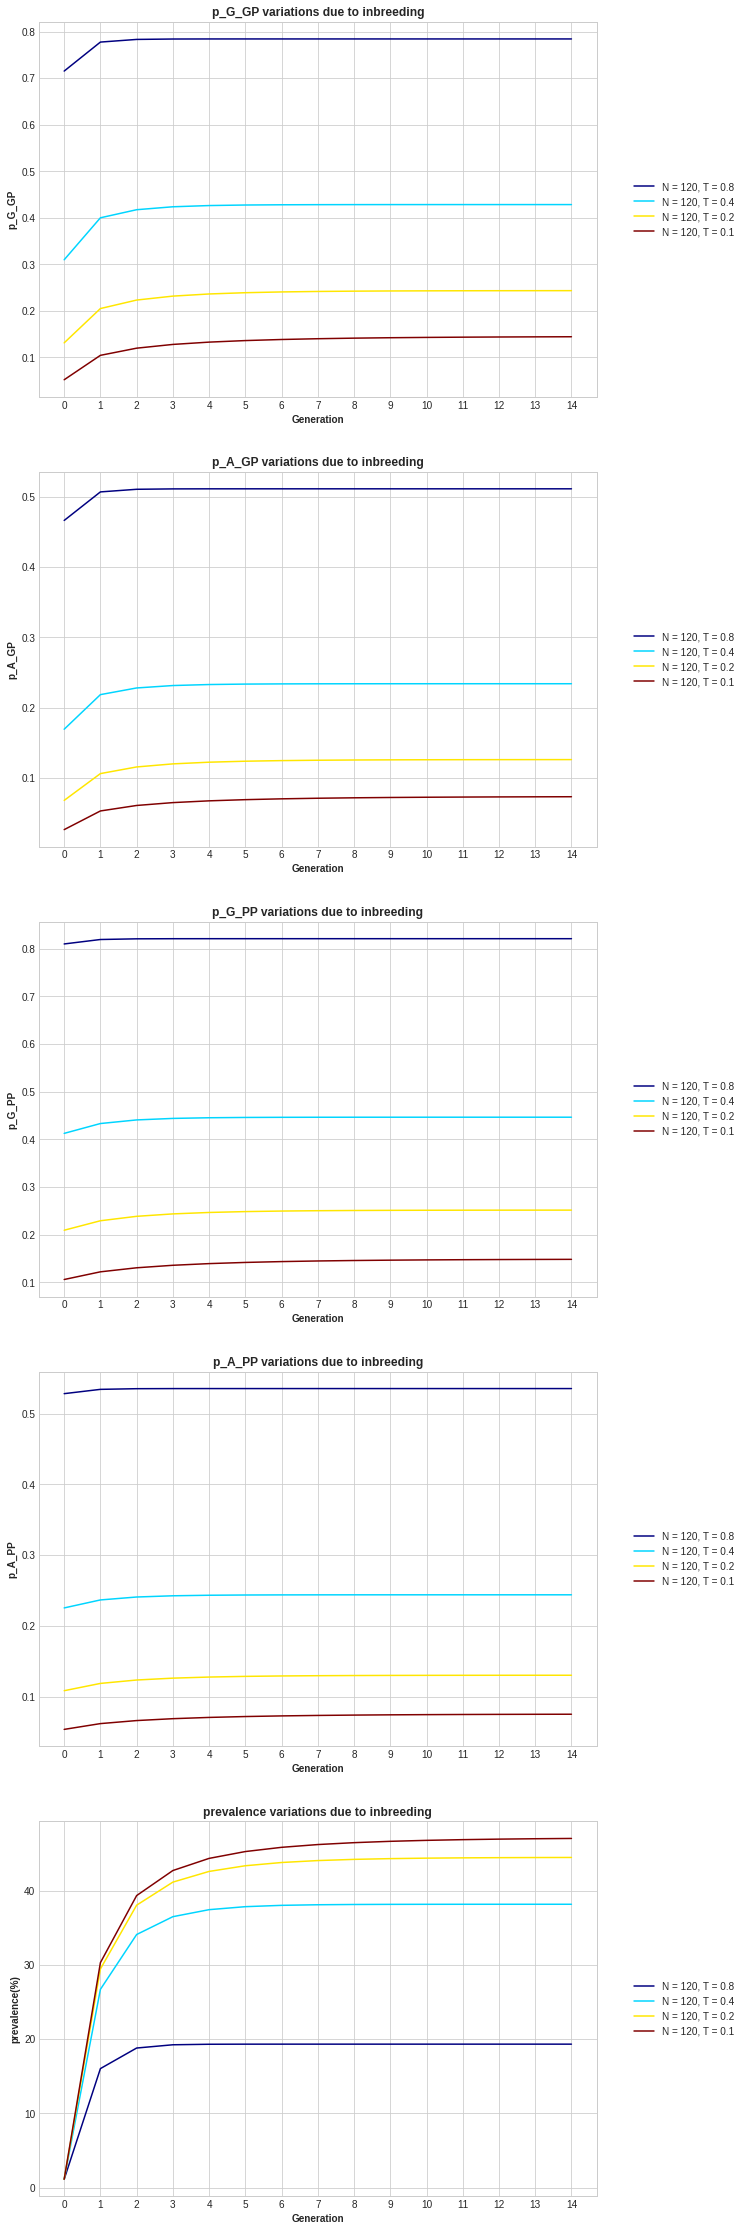

In [ ]:
plot_PP_inbreeding_graphs(120,(0.8,0.4,0.2,0.1))               # will take ~25s to run

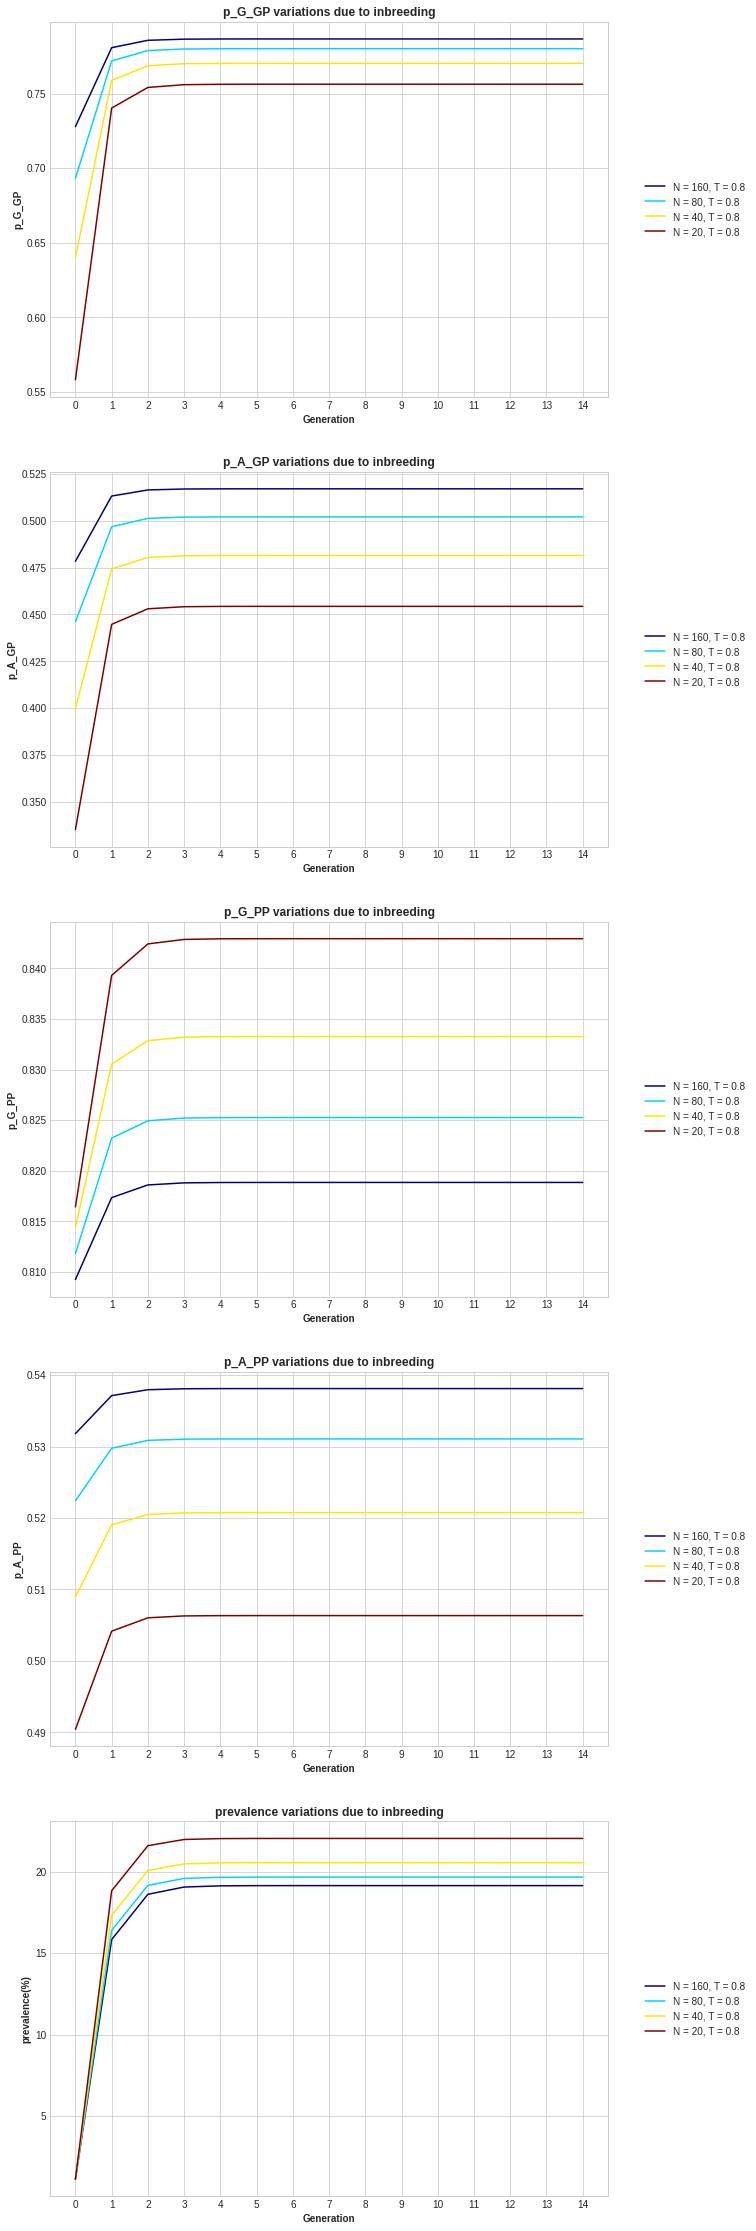

In [ ]:
    plot_PP_inbreeding_graphs((160,80,40,20),0.8)               # will take ~26s to run

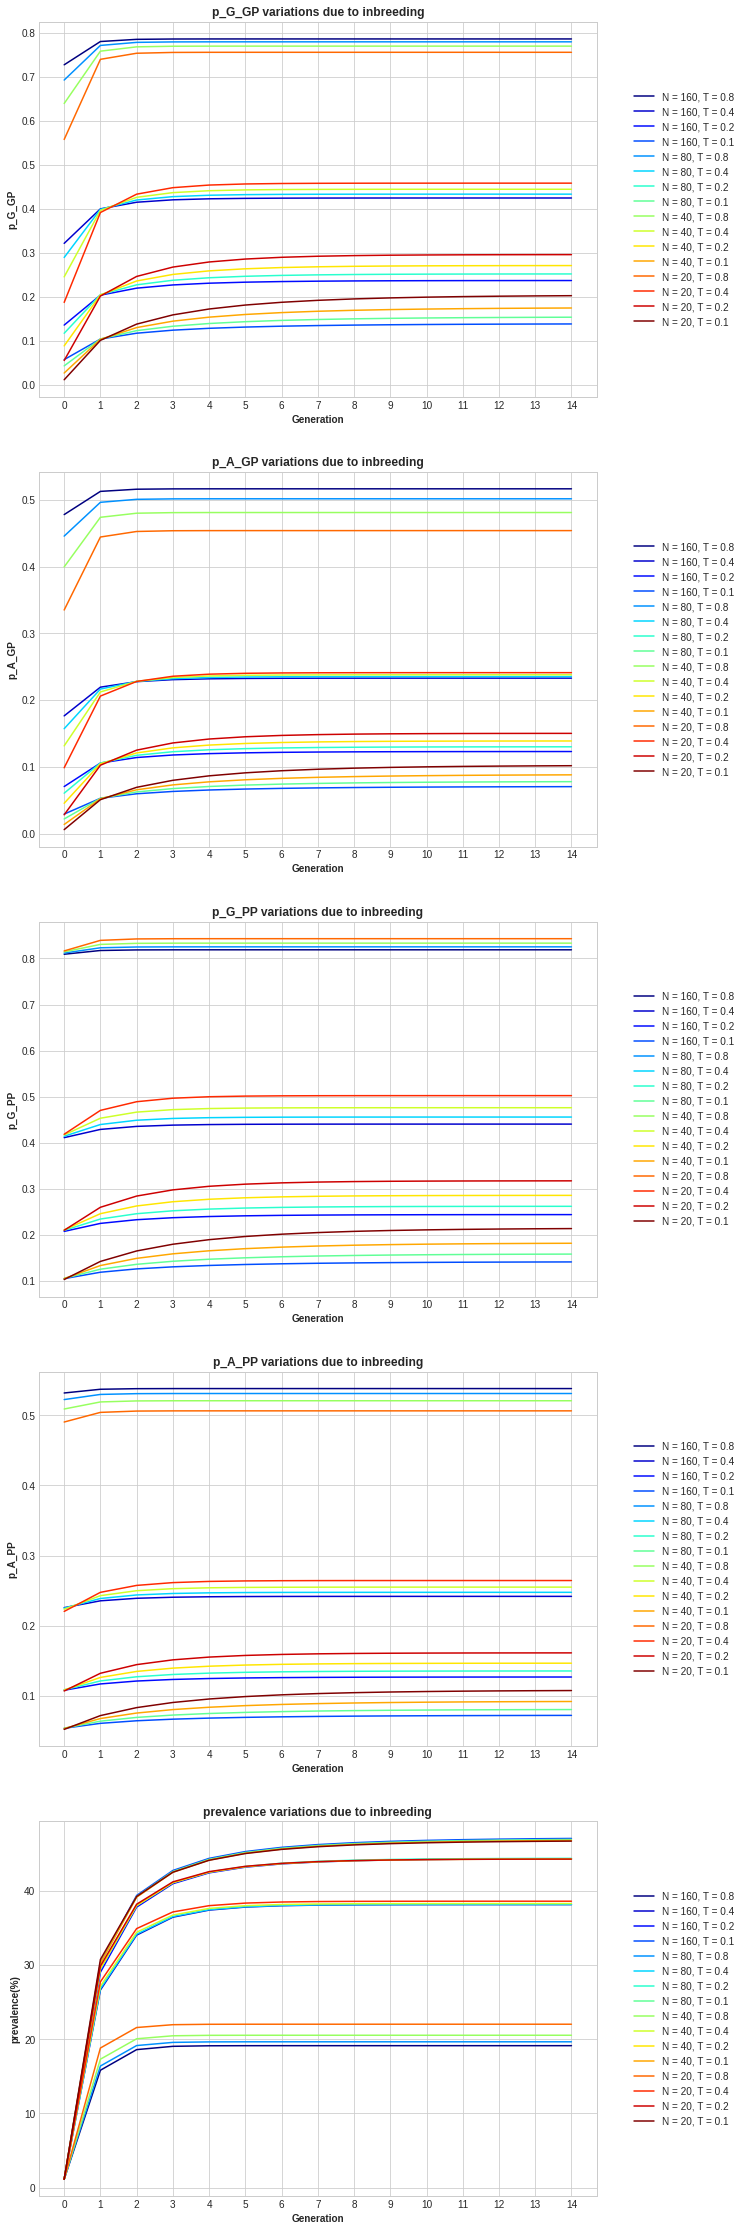

In [ ]:
plot_PP_inbreeding_graphs((160,80,40,20),(0.8,0.4,0.2,0.1))    # will take ~2m to run

## An attempt at reproducing Fig 5 of original research paper. To be continued later, almost done. Not really required for the project but just giving it a shot.

In [ ]:
''' def plot_fig5():                                                            ## Attempt at reproducing Fig 5 graphs in research paper
    fig = plt.figure(figsize=(15, 40))                                          ## Minor errors, abandoned because unnecessary and low priority
    N_vals = [10*i for i in range(2,17)]                                        # 20, 30, ..., 160  (15 values)
    T_vals = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]                # 10 values
    penetrance_vals = [0.25, 0.50, 1.00]                                        # 3 values

    titles = ['Prevalence in the PP × PP offspring'                             # titles for subplots
             ,'Prevalence in the PP x NP offspring'
             ,'Prevalence in the NP x NP offspring']
    lines = ['dashed','solid','dotted']                                         # line styles for different penetrance values
    
    Y = np.zeros(shape=(3,len(penetrance_vals),len(T_vals), len(N_vals)))       # numpy array to store results

    for i in range(3):                                                          # for 3 plots (PPxPP, PPxNP, NPxNP)
        for j in range(len(penetrance_vals)):                                   # for all penetrance vals
            penetrance = penetrance_vals[j]                                      
            for k in range(len(T_vals)):                                        # for all T value brackets
                T = T_vals[k]
                for l in range(len(N_vals)):                                    # for all N values
                    N = N_vals[l]
                    p_GP = calc_all_offspring_p_G_GP(N,T)[i]                    # total # of iters = 3 x 3 x 10 x 15 = 1350
                    Y[i][j][k][l]=100 * calc_prevalence(p_GP,N,T,penetrance)

    for i in range(3):
        ax = fig.add_subplot(3,1,i+1)                                           # add suplot
        ax.invert_xaxis()
        for j in range(len(penetrance_vals)):
            _label_ = 'pen ' +  str(penetrance_vals[j])                         # define label for legend
            _linestyle_ = lines[j]
            for k in range(len(T_vals)):
                partial_X_range = [k - (0.1 / 16) * a for a in range(15)]       # define N mappings in T value brackets
                ax.plot(partial_X_range,Y[i][j][k],linestyle=_linestyle_)
            ax.plot([],[],label=_label_)
        ax.set_xticks(T_vals)
        ax.legend(loc="upper left")
        ax.set_title(titles[i],weight='bold')
        ax.set_xlabel('T brackets for N from 160 to 20')
        ax.set_ylabel('%')
    plt.show() '''

' def plot_fig5():                                                            ## Attempt at reproducing Fig 5 graphs in research paper\n    fig = plt.figure(figsize=(15, 40))                                          ## Minor errors, abandoned because unnecessary and low priority\n    N_vals = [10*i for i in range(2,17)]                                        # 20, 30, ..., 160  (15 values)\n    T_vals = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]                # 10 values\n    penetrance_vals = [0.25, 0.50, 1.00]                                        # 3 values\n\n    titles = [\'Prevalence in the PP × PP offspring\'                             # titles for subplots\n             ,\'Prevalence in the PP x NP offspring\'\n             ,\'Prevalence in the NP x NP offspring\']\n    lines = [\'dashed\',\'solid\',\'dotted\']                                         # line styles for different penetrance values\n    \n    Y = np.zeros(shape=(3,len(penetrance_vals),len(T_vals), len(

In [ ]:
'''plot_fig5()'''

'plot_fig5()'